# SemiEval Restaurant Data Models

This notebook trains classifiers based on the Sem-eval aspect based sentiment analysis restaurant dataset. This is a labelled dataset containing reviews and aspect categories. If reasonable accuracy can be obtained the trained classifier might be useful as a means of automatically tagging the Arun restaurant reviews for aspects.

* Section 1 - Import libraries and dataset
* Section 2 - Data cleaning
* Section 3 - Machine learning models with TFIDF
* Section 4 - Network model with Keras tokenizer
* Section 5 - Word embeddings with the network model
* Section 6 - Using the model trained on the SemEval restaurant data and the best network model to label the Arun food data


# Section 1: Import Libraries and Datasets

Dataset source:

* Sem-eval 2016 Task 5 - Aspect Based Sentiment Analysis
* https://alt.qcri.org/semeval2016/task5/
* Dataset is in XML format transformed to csv using Excel data transform

In [164]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import keras
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

#import spacy
#nlp = spacy.load('en_core_web_sm')
#import textblob
#from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")


In [80]:
df_train = pd.read_csv("Restaurants_Train.csv")
df_test = pd.read_csv("Restaurants_Test.csv")

In [81]:
df_train.head()

,sentences.sentence.text,sentences.sentence.Opinions.Opinion.Attribute:target,sentences.sentence.Opinions.Opinion.Attribute:category,sentences.sentence.Opinions.Opinion.Attribute:polarity,sentences.sentence.Opinions.Opinion.Attribute:from,sentences.sentence.Opinions.Opinion.Attribute:to,sentences.sentence.Attribute:id,Attribute:rid
0,Judging from previous posts this used to be a ...,place,RESTAURANT#GENERAL,negative,51.0,56.0,1004293:0,1004293.0
1,"We, there were four of us, arrived at noon - t...",staff,SERVICE#GENERAL,negative,75.0,80.0,1004293:1,1004293.0
2,"They never brought us complimentary noodles, i...",NaN,SERVICE#GENERAL,negative,0.0,0.0,1004293:2,1004293.0
3,The food was lousy - too sweet or too salty an...,food,FOOD#QUALITY,negative,4.0,8.0,1004293:3,1004293.0
4,The food was lousy - too sweet or too salty an...,portions,FOOD#STYLE_OPTIONS,negative,52.0,60.0,1004293:3,1004293.0


In [82]:
df_test.head()

,sentences.sentence.text,sentences.sentence.Attribute:id,Attribute:rid
0,Yum!,en_BlueRibbonSushi_478218171:0,en_BlueRibbonSushi_478218171
1,Serves really good sushi.,en_BlueRibbonSushi_478218171:1,en_BlueRibbonSushi_478218171
2,Not the biggest portions but adequate.,en_BlueRibbonSushi_478218171:2,en_BlueRibbonSushi_478218171
3,Green Tea creme brulee is a must!,en_BlueRibbonSushi_478218171:3,en_BlueRibbonSushi_478218171
4,Don't leave the restaurant without it.,en_BlueRibbonSushi_478218171:4,en_BlueRibbonSushi_478218171


In [83]:
print(df_train.shape)

(2799, 8)


Note the test reviews are unlabelled!

# Section 2: Exploratory Data Analysis and Pre-processing

In [84]:
df_train.head(2)

,sentences.sentence.text,sentences.sentence.Opinions.Opinion.Attribute:target,sentences.sentence.Opinions.Opinion.Attribute:category,sentences.sentence.Opinions.Opinion.Attribute:polarity,sentences.sentence.Opinions.Opinion.Attribute:from,sentences.sentence.Opinions.Opinion.Attribute:to,sentences.sentence.Attribute:id,Attribute:rid
0,Judging from previous posts this used to be a ...,place,RESTAURANT#GENERAL,negative,51.0,56.0,1004293:0,1004293.0
1,"We, there were four of us, arrived at noon - t...",staff,SERVICE#GENERAL,negative,75.0,80.0,1004293:1,1004293.0


In [85]:
df_train.drop(columns = ["sentences.sentence.Opinions.Opinion.Attribute:from",
                  "sentences.sentence.Opinions.Opinion.Attribute:to",
                  "sentences.sentence.Attribute:id","Attribute:rid"],axis = 1, inplace = True)

In [86]:
df_train.columns

Index(['sentences.sentence.text',
       'sentences.sentence.Opinions.Opinion.Attribute:target',
       'sentences.sentence.Opinions.Opinion.Attribute:category',
       'sentences.sentence.Opinions.Opinion.Attribute:polarity'],
      dtype='object')

In [87]:
df_train.columns = ["Review","Target","Category","Polarity"]

In [88]:
df_train.sample(3)

,Review,Target,Category,Polarity
2469,I book a gorgeous white organza tent which inc...,four course prix fix menu,FOOD#QUALITY,positive
294,"When we stumbled on Leon, we thought that we h...",Leon,RESTAURANT#GENERAL,negative
1009,"Everything was wonderful; food, drinks, staff,...",mileau,AMBIENCE#GENERAL,positive


In [89]:
df_train.Category.value_counts()

FOOD#QUALITY                849
SERVICE#GENERAL             449
RESTAURANT#GENERAL          422
AMBIENCE#GENERAL            255
FOOD#STYLE_OPTIONS          137
RESTAURANT#MISCELLANEOUS     98
FOOD#PRICES                  90
RESTAURANT#PRICES            80
DRINKS#QUALITY               47
DRINKS#STYLE_OPTIONS         32
LOCATION#GENERAL             28
DRINKS#PRICES                20
Name: Category, dtype: int64

In [90]:
df_train.isnull().sum()

Review        0
Target      919
Category    292
Polarity    292
dtype: int64

Target rows missing 627 values out of 2799

In [91]:
df_train = df_train.dropna()

In [92]:
df_train[df_train["Category"]=="DRINKS#PRICES"].head()

,Review,Target,Category,Polarity
12,The wine list is interesting and has many good...,wine list,DRINKS#PRICES,positive
170,Decent wine at reasonable prices.,wine,DRINKS#PRICES,positive
252,"Great wine selection, Gigondas is worth the pr...",house champagne,DRINKS#PRICES,positive
280,The drinks are always welll made and wine sele...,wine selection,DRINKS#PRICES,positive
291,The bar is very well stocked with interesting ...,wines,DRINKS#PRICES,positive


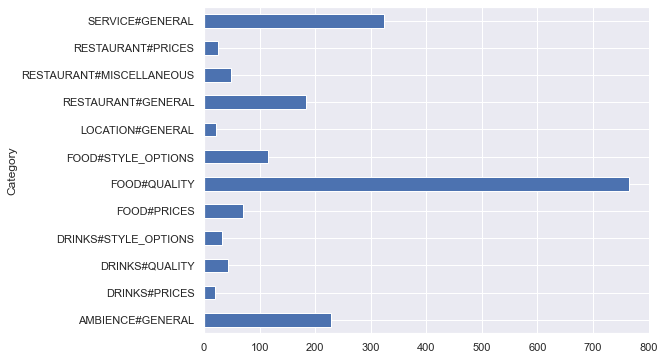

In [93]:
fig = plt.figure(figsize=(8,6))
df_train.groupby('Category').Review.count().plot.barh(ylim=0)
plt.show()

* With imbalanced data, minority classes are treated as outliers and ignored. 
* With say fraud detection or cancer prediction, would require balancing the dataset by undersampling or oversampling
* Here the majority classes is of interest so good prediction on this class with reasonable on the others is acceptable

In [94]:
# Check if null values and drop
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880 entries, 0 to 2798
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    1880 non-null   object
 1   Target    1880 non-null   object
 2   Category  1880 non-null   object
 3   Polarity  1880 non-null   object
dtypes: object(4)
memory usage: 73.4+ KB


In [95]:
# Drop rows where category column is missing
df_train = df_train.dropna(axis=0, subset=['Category'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880 entries, 0 to 2798
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    1880 non-null   object
 1   Target    1880 non-null   object
 2   Category  1880 non-null   object
 3   Polarity  1880 non-null   object
dtypes: object(4)
memory usage: 73.4+ KB


In [96]:
df_train.Target.value_counts()

food                     216
place                    124
service                  121
restaurant                47
staff                     38
                        ... 
VT's                       1
antipasti                  1
japanese comfort food      1
Tom Kha soup               1
Chilli Chicken             1
Name: Target, Length: 721, dtype: int64

In [97]:
df_train.Polarity.value_counts()

positive    1319
negative     489
neutral       72
Name: Polarity, dtype: int64

In [98]:
# Drop neutral sentiment reviews
#df_train = df_train[df_train["Polarity"] != "neutral"]

In [99]:
print("Maximum string length:",df_train.Review.str.split().apply(len).max())
print("Minimum string length:",df_train.Review.str.split().apply(len).min())
print("Median string length:",df_train.Review.str.split().apply(len).median())
print("Mean string length:",df_train.Review.str.split().apply(len).mean())

Maximum string length: 57
Minimum string length: 1
Median string length: 13.0
Mean string length: 14.925531914893616


Review sentences are quite short to a maximum of 57 tokens. The mean and median are similar so the dataset is fairly normally distributed

In [100]:
# Look at test data
df_test.head(2)

,sentences.sentence.text,sentences.sentence.Attribute:id,Attribute:rid
0,Yum!,en_BlueRibbonSushi_478218171:0,en_BlueRibbonSushi_478218171
1,Serves really good sushi.,en_BlueRibbonSushi_478218171:1,en_BlueRibbonSushi_478218171


In [102]:
# Drop unwanted columns and rename
df_test.drop(columns = ["sentences.sentence.Attribute:id","Attribute:rid"],axis =1, inplace = True)
df_test.columns = ["Review"]
df_test.head(2)

,Review
0,Yum!
1,Serves really good sushi.


# Section 3: Machine Learning Models

Reference paper: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [103]:
# Convert the Category to categorical and set y 
df_train['category_id'] = df_train['Category'].factorize()[0]
y = df_train.category_id

In [208]:
# Encode as binary
label_encoder = preprocessing.LabelEncoder()
cat = label_encoder.fit_transform(df_train.category_id)
y = to_categorical(cat)

In [210]:
# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train['Target'], 
                                                    df_train['category_id'],test_size = 0.2, random_state = 0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1504,) (376,) (1504,) (376,)


In [211]:
# Set vectorizer for bigrams using tfidf
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
len(tfidf.vocabulary_)

1091

In [212]:
# Stratified K Fold
def strat(model, X_train,y_train,vector):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train,y_train, cv=kfold)
    mean = cv_results.mean()
    df = pd.DataFrame({vector:mean},index = [0])
    return df

In [213]:
# Define models
clf1 = LogisticRegression(random_state=0, class_weight = "balanced")
clf2 = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight = "balanced")
clf3 = LinearSVC(class_weight = "balanced")
clf4 = SVC(class_weight = "balanced")

In [214]:
a = strat(clf1, X_train_tfidf, y_train,"LR")
b = strat(clf2, X_train_tfidf, y_train,"RF")
c = strat(clf3, X_train_tfidf, y_train,"LSVC")
d = strat(clf4, X_train_tfidf, y_train, "SVM")
models = pd.concat([a,b,c,d],axis = 1)

In [215]:
models

,LR,RF,LSVC,SVM
0,0.474071,0.372269,0.694168,0.473395


Training accuracy pretty bad

# Section 4: Deep Learning Model with Keras Tokenizer

* The full training set is used since network models usually perform better with more data
* The test set is unlabelled but a manual examination of predicted aspects will be used to determine how well the model works as well as the training accuracy

In [181]:
# Tokenize reviews
vocab_size = 6000 
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_train.Review)
reviews_tokenized = tokenizer.texts_to_matrix(df_train.Review)

In [202]:
label_encoder = preprocessing.LabelEncoder()
cat = label_encoder.fit_transform(df_train.Category)
y_train = to_categorical(cat)

In [198]:
# Build model

model_1 = Sequential()
model_1.add(Dense(512, input_shape=(6000,), activation='relu'))
model_1.add(Dropout(rate=0.5))
model_1.add((Dense(256, activation='relu')))
model_1.add(Dropout(rate=0.5))
model_1.add((Dense(128, activation='relu')))
model_1.add((Dropout(rate = 0.5)))
model_1.add(Dense(12, activation='softmax'))

#compile model
model_1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [205]:
model_1.fit(reviews_tokenized, y_train,
                       epochs = 50,
                       verbose = 0,
                       batch_size = 8,
                       )

In [206]:
# Get training accuracy of the model
loss, accuracy = model_1.evaluate(reviews_tokenized, y, verbose=1)
print('Training Accuracy is {}'.format(accuracy*100))

59/59 [==============================] - 0s 2ms/step - loss: 0.3858 - accuracy: 0.7670
Training Accuracy is 76.70212984085083


* The training accuracy of 77% is ok but not great 

# Section 5: Word Embeddings

Reference paper: https://heartbeat.fritz.ai/using-a-keras-embedding-layer-to-handle-text-data-2c88dc019600

In [216]:
# Set X_training, test and y training variables (again the test set is unlabelled as per Sem-eval)
X_train= df_train["Review"]
y_train = df_train["Category"]
X_test = df_test["Review"]

Use full df_train dataset for training as neural networks usually work better with more data. The test set is unlabelled but a range of results will be examined manually

In [217]:
# One hot encode the X variables with a vocab size of 10000

vocab_size = 6000


X_train = [one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',lower=True, split=' ') for d in X_train]
X_test = [one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',lower=True, split=' ') for d in X_test]


In [218]:
# Example tokenized review
print(X_train[1])

[3048, 5957, 1320, 3376, 4113, 2166, 3219, 2203, 4634, 5610, 1606, 2515, 3354, 4807, 5610, 1682, 3620, 391, 3048, 1320, 4776, 2031, 2500, 4807, 914, 1320, 903, 3759]


In [219]:
# Set the maximum length of review based on analysis of mean, min and max review length earlier and pad sequences to same 
# length using padding 'pre' ('post' can also be used but as most reviews are the same length, it shouldn't make much difference)
max_length = 50
X_train = pad_sequences(X_train, maxlen=max_length, padding='pre')
X_test = pad_sequences(X_test, maxlen=max_length, padding='pre')

In [220]:
# Check sample
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 1489, 4974, 4513,  143, 1957, 4705,  225, 5590, 2715,
       3930, 1606, 5435, 5762, 4201, 1888])

In [221]:
# Encode target categories

label_encoder = LabelEncoder()
cat = label_encoder.fit_transform(y_train)
y_train = to_categorical(cat)


In [222]:
# Check exampled
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [223]:
# Set embedding parameters
input_dim = vocab_size
output_dim = 16
input_length = max_length

In [224]:
# Build model
model_2 = Sequential()
model_2.add(Embedding(input_dim, output_dim = output_dim, input_length=max_length))
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(rate=0.5))
model_2.add((Dense(256, activation='relu')))
model_2.add(Dropout(rate=0.5))
model_2.add((Dense(128, activation='relu')))
model_2.add((Dropout(rate = 0.5)))
model_2.add(Dense(12, activation='softmax'))

#compile model
model_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

print(model_2.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            96000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               410112    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)              

In [225]:
history = model_2.fit(X_train, y_train, epochs=50, verbose=0)

In [226]:
loss, accuracy = model_2.evaluate(X_train, y_train, verbose=1)
print('Training Accuracy is {}'.format(accuracy*100))

59/59 [==============================] - 0s 507us/step - loss: 0.4094 - accuracy: 0.7676
Training Accuracy is 76.75532102584839


* The tokenized and word embedding models performed very much the same with around 76% accuracy on the training set 
* Performance may be improved using pre-trained word embeddings such as Word2Vec but at the same time they might have less relevent corpora.

# Section 6: Aspect Labelling of Arun Restaurants Dataset

In [249]:
# Read in data
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD", engine = "openpyxl")

# Drop column
df_food.drop(["Category"],axis = 1,inplace = True)

In [261]:
df_food = df_food.sample(frac = 1)

In [262]:
# Tokenize the nouns
vocab_size = 6000 
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_food.Nouns)
reviews_tokenized_arun = tokenizer.texts_to_matrix(df_food.Nouns)

In [263]:
y_pred_prob = model_1.predict(reviews_tokenized_arun)
y_pred_class = np.argmax(model_1.predict(reviews_tokenized_arun), axis=-1)
y_pred_class

array([4, 4, 4, ..., 5, 5, 5], dtype=int64)

In [264]:
# Models output (use Model 1 which seemed to perform slightly better)
aspects = pd.DataFrame(label_encoder.inverse_transform(np.argmax(model_1.predict(reviews_tokenized_arun), axis=-1)))
aspects.columns = ["Aspect"]

In [265]:
aspects.shape

(2100, 1)

In [266]:
food = pd.concat([df_food.reset_index(),aspects],axis = 1,ignore_index = True)
food.drop(columns = [0,1,2,3,5,7,8],axis = 1,inplace = True)
food.columns = ["Nouns","Aspect","Predicted"]

In [267]:
food.head()

,Nouns,Aspect,Predicted
0,staff,Staff&Service,FOOD#PRICES
1,value money,Value,FOOD#PRICES
2,value money,Value,FOOD#PRICES
3,staff surroundings,Staff&Service,FOOD#PRICES
4,staff,Staff&Service,FOOD#PRICES


In [268]:
food.Predicted.value_counts()

FOOD#PRICES                 1374
FOOD#QUALITY                 416
SERVICE#GENERAL              120
RESTAURANT#GENERAL            86
RESTAURANT#MISCELLANEOUS      40
AMBIENCE#GENERAL              25
DRINKS#PRICES                 17
RESTAURANT#PRICES             12
DRINKS#QUALITY                 4
DRINKS#STYLE_OPTIONS           3
LOCATION#GENERAL               2
FOOD#STYLE_OPTIONS             1
Name: Predicted, dtype: int64

Fairly unsuccessful!